In [1]:
# Display the avg location of a particular structure in the mean shape of the matched dataset

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdgesExt
Tue May  3 09:07:30 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
# local_staging_variance_edges is generated by using the output dataframe from the
# mapping process to filter out not matched cells from the baseline dataset.
dsname = "edges"
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    dsname: {
        "control": f"{path_cvapipe}/local_staging_variance_edges",
        "perturbed": f"{path_cvapipe}/local_staging_edge_cells_midpoint_expanded"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)
df_map = smapper.result
df_map.head()

	edges loaded. (5169, 1255)


NUC_MEM_PC1  NUC_MEM_PC2  NUC_MEM_PC3  \
dataset structure_name CellId                                          
base    AAVS1          466245    -0.268392    -0.829342     0.047623   
                       466246    -0.243572    -0.607768     0.631536   
                       466248    -0.402700    -0.944572    -0.832112   
                       466252     0.204445     0.848568     0.504295   
                       466254    -0.560492     0.529491     0.330510   

                               NUC_MEM_PC4  NUC_MEM_PC5  NUC_MEM_PC6  \
dataset structure_name CellId                                          
base    AAVS1          466245     1.605686     2.121168     4.532400   
                       466246     0.183432    -0.023279     0.018518   
                       466248    -0.943582     1.107919     0.192331   
                       466252     1.485295     1.869869    -1.348346   
                       466254    -0.276561    -0.058453    -0.889613   

                               NUC_MEM_PC7  NUC_MEM_PC8  Dist  SelfDist  \
dataset structure_name CellId                                             
base    AAVS1          466245    -1.457947    -1.057389   NaN       NaN   
                       466246    -0.563475     0.252743   NaN       NaN   
                       466248     1.015603     2.536074   NaN       NaN   
                       466252    -0.242532     0.777132   NaN       NaN   
                       466254     1.469526    -0.531597   NaN       NaN   

                               NNCellId  Match  edges  
dataset structure_name CellId                          
base    AAVS1          466245        -1  False  False  
                       466246        -1  False  False  
                       466248        -1  False   True  
                       466252        -1  False  False  
                       466254        -1  False  False

### Loading and voxelizing matched shape

In [8]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{inner_alias}_matched.vtk"
inner_mesh = device.read_vtk_polydata(fname)
outer_alias = control.get_outer_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{outer_alias}_matched.vtk"
outer_mesh = device.read_vtk_polydata(fname)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [9]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

### Control and Device for each shape matched dataset (control and perturbed)

In [10]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdgesExt/../tools/common.py'>

In [11]:
dsmanagers = common.setup_cvapipe_for_matched_dataset(config, datasets[dsname])

### Load and aggregate representations

In [12]:
# namemap = {"control": "base", "perturbed": dsname}
conds = ["control", "perturbed"]
genes = ["TUBA1B", "LAMP1", "ST6GAL1", "ACTB", "MYH10", "CTNNB1", "ACTN1"]

In [13]:
reps = {}
for gene in genes:
    df_gene = df_map.loc[(dsname,gene)]
    CondCellIds = {"perturbed": df_gene.index.values, "control": df_gene.NNCellId.unique()}
    for cond, CellIds in CondCellIds.items():
        reps[f"{gene}_{cond}"] = common.get_all_norm_parameterized_intensity_of_seg_channel(CellIds, dsmanagers[cond]["device"]).mean(axis=0)

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

### Morphing aggregatate representation into matched shape

In [14]:
data = {}
for gene in genes: 
    for cond in conds:
        name = f"{gene}_{cond}"
        morphed = cytoparam.morph_representation_on_shape(
            img=domain,
            param_img_coords=coords_param,
            representation=reps[name]
        )
        morphed /= morphed.sum()
        data[name] = np.stack([domain_nuc, domain_mem, morphed], axis=0)

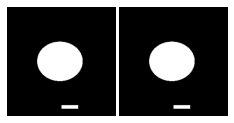

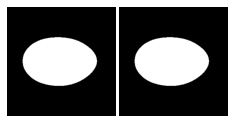

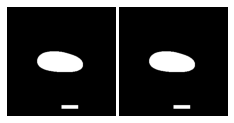

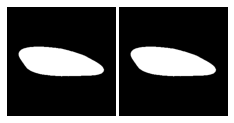

In [15]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
for orient in ["z", "y"]:
    for alias in ["nuc", "mem"]:
        fig, axs = plt.subplots(1,2, figsize=(4, 2), **args)
        for ax, cond in zip(axs, conds):
            ax.axis("off")
            instance = data[f"{genes[0]}_{cond}"]
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=orient, mode=mode)
            proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
        plt.savefig(f"FigureEdgesExt1_{alias}_{orient}.png", dpi=150)
        plt.show()

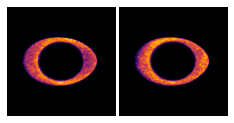

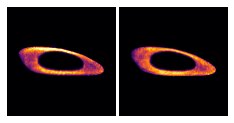

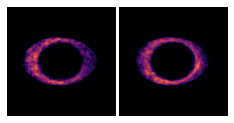

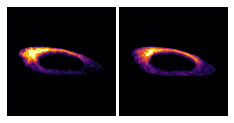

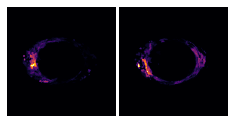

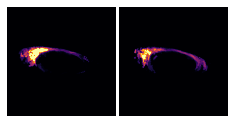

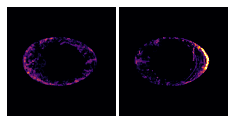

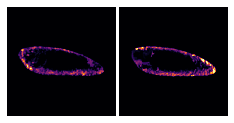

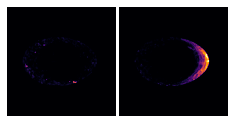

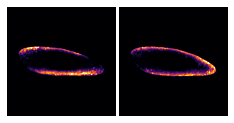

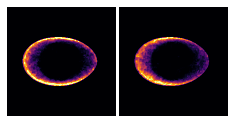

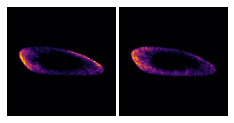

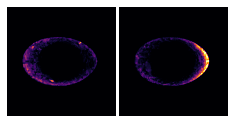

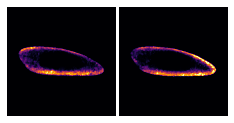

In [16]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
for gene in genes:
    instances = [data[f"{gene}_{cond}"] for cond in conds]
    vmin, vmax = common.Projector.get_shared_gfp_range(instances, [20,98])
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,2, figsize=(4, 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias="gfp", ax=ax)
            view.set_clim(vmin, vmax)
        plt.savefig(f"FigureEdges1_{gene}_gfp_{orient}.png", dpi=150)
        plt.show()

In [17]:
common.now("complete")

complete 2022-05-03 09:11:32
